## **Import Libraries and Functions**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import time
from datetime import datetime, timedelta
from functools import reduce
import warnings
import sqlite3

## **Read the data**

In [20]:
df = pd.read_csv('retention_data(masked).csv')
df

,RecordDate,RecordMonth,CustomerGroup,Location,Revenue
0,2022-12-01,2022-12-01,Bronze,Location 01,8.314055e+08
1,2022-12-01,2022-12-01,Bronze,Location 02,2.438621e+09
2,2022-12-01,2022-12-01,Bronze,Location 03,4.669991e+09
3,2022-12-01,2022-12-01,Bronze,Location 04,6.437171e+09
4,2022-12-01,2022-12-01,Bronze,Location 06,1.601231e+09
...,...,...,...,...,...
41141,2023-12-31,2023-12-01,Unranked,Location 12,4.006081e+09
41142,2023-12-31,2023-12-01,Unranked,Location 13,2.425535e+09
41143,2023-12-31,2023-12-01,Unranked,Location 14,3.022785e+09
41144,2023-12-31,2023-12-01,Unranked,Location 16,2.017989e+09


In [21]:
df.dtypes

RecordDate        object
RecordMonth       object
CustomerGroup     object
Location          object
Revenue          float64
dtype: object

## <font color='red'>**Calculate Retention Revenue** </font>

* How to calculate % Retention Revenue: 
    * let x = Revenue of ranked customer in month M
    * let y = Total revenue of month M - 1
    
Formula: $\Large\% Retention Revenue = \frac{x}{y}$

#### RevenueRankedCustomers

In [25]:
df_revenue_rc = df.loc[df['CustomerGroup'] != 'Unranked']
df_revenue_rc['RecordMonth'] = pd.to_datetime(df_revenue_rc['RecordMonth'])
df_revenue_rc

C:\Users\duyta\AppData\Local\Temp\ipykernel_20048\1873106098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue_rc['RecordMonth'] = pd.to_datetime(df_revenue_rc['RecordMonth'])


,RecordDate,RecordMonth,CustomerGroup,Location,Revenue
0,2022-12-01,2022-12-01,Bronze,Location 01,8.314055e+08
1,2022-12-01,2022-12-01,Bronze,Location 02,2.438621e+09
2,2022-12-01,2022-12-01,Bronze,Location 03,4.669991e+09
3,2022-12-01,2022-12-01,Bronze,Location 04,6.437171e+09
4,2022-12-01,2022-12-01,Bronze,Location 06,1.601231e+09
...,...,...,...,...,...
41126,2023-12-31,2023-12-01,Silver,Location 12,3.331863e+09
41127,2023-12-31,2023-12-01,Silver,Location 13,1.451781e+09
41128,2023-12-31,2023-12-01,Silver,Location 14,2.910031e+09
41129,2023-12-31,2023-12-01,Silver,Location 16,1.473058e+09


In [26]:
df_revenue_rc_gb = df_revenue_rc.groupby('RecordMonth').agg(RevenueRC = ('Revenue', 'sum')).reset_index()
df_revenue_rc_gb

,RecordMonth,RevenueRC
0,2022-12-01,8.351435e+12
1,2023-01-01,5.663964e+12
2,2023-02-01,6.446328e+12
3,2023-03-01,7.690316e+12
4,2023-04-01,6.966814e+12
5,2023-05-01,7.357767e+12
6,2023-06-01,7.207830e+12
7,2023-07-01,7.863555e+12
8,2023-08-01,8.291726e+12
9,2023-09-01,7.633836e+12


In [27]:
df_revenue_rc_gb.dtypes

RecordMonth    datetime64[ns]
RevenueRC             float64
dtype: object

#### Revenue Total Customers

In [28]:
df_revenue_tc = df.copy()

In [29]:
df_revenue_tc['RecordMonth'] = pd.to_datetime(df_revenue_tc['RecordMonth'], errors = 'coerce')

In [30]:
df_revenue_tc_gb = df_revenue_tc.groupby('RecordMonth').agg(TotalRevenue = ('Revenue', 'sum')).reset_index()
df_revenue_tc_gb

,RecordMonth,TotalRevenue
0,2022-12-01,9.040111e+12
1,2023-01-01,5.850252e+12
2,2023-02-01,7.248756e+12
3,2023-03-01,8.389111e+12
4,2023-04-01,7.666508e+12
5,2023-05-01,8.053928e+12
6,2023-06-01,7.820192e+12
7,2023-07-01,8.647735e+12
8,2023-08-01,8.942473e+12
9,2023-09-01,8.176198e+12


#### Merge Data

In [62]:
df_merge = pd.merge_asof(df_revenue_rc_gb, df_revenue_tc_gb, on = 'RecordMonth', allow_exact_matches= False)
df_merge['PercentageRetentionRevenue'] = df_merge['RevenueRC']/df_merge['TotalRevenue']
df_merge.dropna(inplace = True)
df_merge

,RecordMonth,RevenueRC,TotalRevenue,PercentageRetentionRevenue
1,2023-01-01,5.663964e+12,9.040111e+12,0.626537
2,2023-02-01,6.446328e+12,5.850252e+12,1.101889
3,2023-03-01,7.690316e+12,7.248756e+12,1.060915
4,2023-04-01,6.966814e+12,8.389111e+12,0.830459
5,2023-05-01,7.357767e+12,7.666508e+12,0.959729
6,2023-06-01,7.207830e+12,8.053928e+12,0.894946
7,2023-07-01,7.863555e+12,7.820192e+12,1.005545
8,2023-08-01,8.291726e+12,8.647735e+12,0.958832
9,2023-09-01,7.633836e+12,8.942473e+12,0.853661
10,2023-10-01,7.905924e+12,8.176198e+12,0.966944


#### Visualization

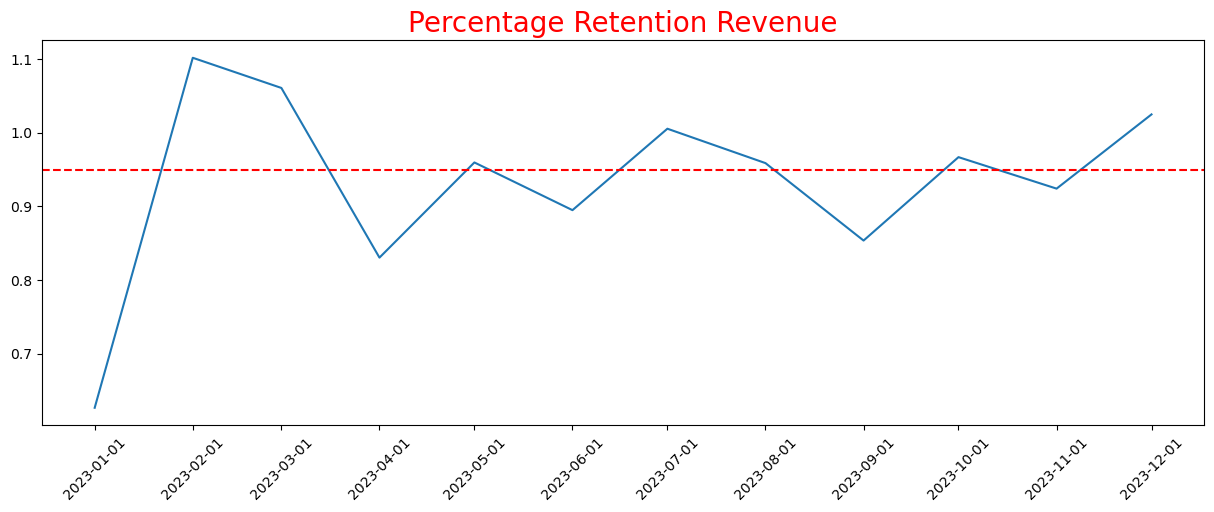

In [83]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111)

ax1.plot(df_merge['RecordMonth'], df_merge['PercentageRetentionRevenue'])
ax1.axhline(y = 0.95, color = 'red', linestyle = 'dashed') 
ax1.set_xticks(df_merge['RecordMonth'])
plt.title('Percentage Retention Revenue', fontsize=20, color="Red")
plt.xticks(rotation = 45)
plt.show()